Попытка решить проблему слишком большого количества классов

In [333]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [334]:
# количество итераций обучения
NUM_OF_ITERATIONS = 50

# читаем размеченные данные из файла
beer_dataset = pd.read_excel('beer_data_set.xlsx')

# печатаем список колонок таблички чтобы удобнее было копировать
print('\n'.join(beer_dataset.columns))

# выводим несколько первых строк таблицы
beer_dataset.head()

barcode
SKU_NAME
Наименование
Алкоголь
Объем
Производитель
Бренд
Саб-бренд
Тип упаковки
Мультипак
тип


,barcode,SKU_NAME,Наименование,Алкоголь,Объем,Производитель,Бренд,Саб-бренд,Тип упаковки,Мультипак,тип
0,4600721002206,Пиво БагБир 0.5л ст/бут,BAGBIER - светлое - 4.2% - 0.5л стекло,0.042,0.5,AB InBev,BAGBIER,NaN,Стекло,NaN,Светлое
1,4600721003197,Пиво БАГ-БИР св.ст/б 0.5л,BAGBIER - светлое - 4.2% - 0.5л стекло,0.042,0.5,AB InBev,BAGBIER,NaN,Стекло,NaN,Светлое
2,4600721003203,"Пиво BAGBIER светлое 4,9% 1.5л",BAGBIER - светлое - 4.9% - 1.5л пэт,0.049,1.5,AB InBev,BAGBIER,NaN,ПЭТ,NaN,Светлое
3,4600721005191,Пиво БАГ-БИР св.ПЭТ 2.5л,BAGBIER - светлое - 4.2% - 2.5л пэт,0.042,2.5,AB InBev,BAGBIER,NaN,ПЭТ,NaN,Светлое
4,4600721009366,"Пиво БАГ БИР ГОЛЬДЕН светлое ПЭТ 4% 1,5л",BAGBIER GOLDEN - светлое - 4.7% - 1.5л пэт,0.047,1.5,AB InBev,BAGBIER,Golden,ПЭТ,NaN,Светлое


In [335]:
import re 
import random
import time
from json import dumps

random.seed(time.time())
analyzer = 'word'
token_pattern = r"(?m)[a-zA-Zа-яА-Я]+|[0-9]+[\.,][0-9]+[\w\%]|[0-9]+[\.,][0-9]+"

def quote(s):
    return s

def tokenize(items, token_pattern):
    pat = re.compile(token_pattern)
    tokens = ['; '.join(quote(match.group()) for match in re.finditer(pat, item)) for item in items ]
    data = zip(items, tokens)
    return pd.DataFrame(data, columns=['Строка', 'Токены'])

tokenize(random.sample(data, 10), token_pattern)

,Строка,Токены
0,ZHIGULYOVSK.(DEKA/NOVGOROD) 1.5L P BO L X,ZHIGULYOVSK; DEKA; NOVGOROD; 1.5L; P; BO; L; X
1,STAVGOROD NEFILTROVANNOE 1L NF L Z X,STAVGOROD; NEFILTROVANNOE; L; NF; L; Z; X
2,"Пиво ВИЗИТНОЕ св.5,1% 1.5л","Пиво; ВИЗИТНОЕ; св; 5,1%; 1.5л"
3,Пиво KRUSOVICE IMPERIAL св.ст/б 0.33л,Пиво; KRUSOVICE; IMPERIAL; св; ст; б; 0.33л
4,"Пиво РИЖСКОЕ св.паст.4,8% 1.5л","Пиво; РИЖСКОЕ; св; паст; 4,8%; 1.5л"
5,CERNOVAR CERNE 0.5L J BO D F,CERNOVAR; CERNE; 0.5L; J; BO; D; F
6,НЕВСКОЕ - светлое 4.7% - 0.44л стекло,НЕВСКОЕ; светлое; 4.7%; 0.44л; стекло
7,"Пиво LEFFE BLONDE св.6,6% ст/б 0.33л","Пиво; LEFFE; BLONDE; св; 6,6%; ст; б; 0.33л"
8,VELKOPOPOVICKY KOZEL - нефильтрованное светлое...,VELKOPOPOVICKY; KOZEL; нефильтрованное; светло...
9,Пиво BUDWEISER BUDVAR св.5% ст/б 0.5л,Пиво; BUDWEISER; BUDVAR; св; ст; б; 0.5л


In [336]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, normalize
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

data = [item for item in beer_dataset[['SKU_NAME']].values.flatten()]
labels = [item.lower() for item in beer_dataset['Бренд'].values.flatten()]
full_train_data, test_data, full_train_labels, test_labels = train_test_split(data, labels, test_size=0.33, random_state=42)

delim = len(full_train_data)//4

train_data, val_data = full_train_data[delim:], full_train_data[:delim]
train_labels, val_labels = full_train_labels[delim:], full_train_labels[:delim]

def intersect(doc, label):
    doc_tokens = set(doc.lower().split())
    label_tokens = set(label.lower().split())
    if len(doc_tokens.intersection(label_tokens)) > 0:
        return 1
    return 0

def enrich(vectors, data, labels):
    padding = np.array([[intersect(data[i], label) for i, label in enumerate(labels)]]).transpose()
    enriched = np.concatenate((vectors.todense(), padding), axis=1)
    return normalize(enriched, axis=1)

def build_model(data, labels, val_data, val_labels, iterations=200):
        vectorizer = CountVectorizer(lowercase=True,
                                    max_df=0.4,
                                    analyzer='word',
                                    stop_words=['пиво'],
                                    token_pattern=token_pattern)
        vectorizer.fit(data+val_data)
        vectorized_data = enrich(vectorizer.transform(data), data, labels)
        vectorized_val_data = enrich(vectorizer.transform(val_data), val_data, val_labels)
            
        le = LabelEncoder()
        le.fit(labels+val_labels)
        encoded_labels = to_categorical(le.transform(labels))
        encoded_val_labels = to_categorical(le.transform(val_labels))
        # encoded_labels = to_categorical(labels)
        # encoded_val_labels = to_categorical(val_labels)
        
        input_dim = vectorized_data.shape[1]
        classes = encoded_labels.shape[1]
        dropout = 0.3
        
        classifier = Sequential()
        for layer in [
            Dense(input_dim, input_dim=input_dim),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
           # Dense(classes, activation='relu'),
           # Dropout(dropout),
            Dense(classes, activation='softmax')
        ]: classifier.add(layer)
            
        classifier.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
        classifier.summary()
        h = classifier.fit(vectorized_data, 
                           encoded_labels, 
                           epochs=10, 
                           batch_size=32,
                          validation_data=(vectorized_val_data, encoded_val_labels))
        return (vectorizer, 
                le, 
                classifier, 
                h)



In [337]:
model = build_model(train_data, train_labels, val_data, val_labels)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_133 (Dense)            (None, 1805)              3259830   
_________________________________________________________________
dense_134 (Dense)            (None, 441)               796446    
Total params: 4,056,276
Trainable params: 4,056,276
Non-trainable params: 0
_________________________________________________________________
Train on 2927 samples, validate on 975 samples
Epoch 1/10
2927/2927 [==============================] - 20s 7ms/step - loss: 4.7596 - acc: 0.1811 - val_loss: 3.9796 - val_acc: 0.3344
Epoch 2/10
2927/2927 [==============================] - 6s 2ms/step - loss: 3.0285 - acc: 0.5347 - val_loss: 2.8663 - val_acc: 0.5949
Epoch 3/10
2927/2927 [==============================] - 6s 2ms/step - loss: 1.9352 - acc: 0.7468 - val_loss: 2.2289 - val_acc: 0.6913
Epoch 4/10
2927/2927 [==============================] - 6s 2ms/step - loss: 1.

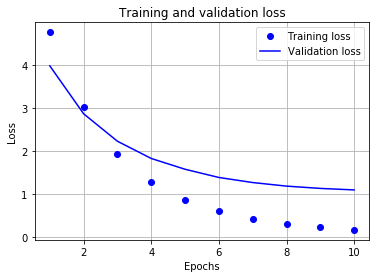

In [338]:
import seaborn as sb
history = model[3]

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

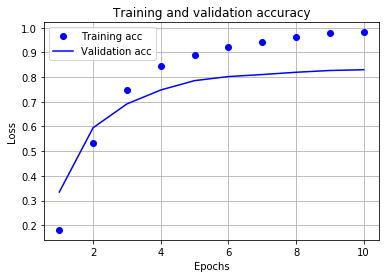

In [339]:
plt.clf()   # clear figure
acc_values =  history.history['acc']
val_acc_values =  history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [340]:
(vectorizer, le, classifier, h) = model
xx = enrich(vectorizer.transform(test_data), test_data, test_labels)

predictions = [pred.argmax() for pred in classifier.predict(xx)]

    
decoded_predictions = le.inverse_transform(predictions).flatten()

valid = sum(1 for i, prediction in enumerate(decoded_predictions)
           if prediction == test_labels[i])
print(f"Valid answers: {100*valid/len(test_data)}\%")

invalid_preds = [(test_data[i], prediction, test_labels[i]) 
                 for i, prediction in enumerate(decoded_predictions)
                 if prediction != test_labels[i]]

invalid = pd.DataFrame(invalid_preds, columns=['Входные данные', 'Предсказание', 'Правильный ответ'])
invalid.head(50)

Valid answers: 84.0270551508845\%


,Входные данные,Предсказание,Правильный ответ
0,"ПивоANDECH.ВАЙСБ.ХЕФЕТР.св.5,5%ст/б 0.5л",hacker-pschorr,andechser vollbier hell
1,ZOLOTOY KHMEL SVETLOE 0.5L J BO L X,джой,золотой хмель
2,ВОЛКОВСКАЯ ПИВОВАРНЯ - нефильтрованное светлое...,oettinger,волковская пивоварня
3,"Пиво ГУЛЬДЕН ДРААК тем.10,5% ст/б 0.75л",dominus,gulden draak
4,OBOLON`(MOSK.PIV.KO.) SVETLOE 2L P BO L C,hollandia,оболонь
5,Пиво СОКОЛ Класс.5% св.бут 0.5л,staropramen,efes
6,BIZON(OSHA/OMSK) SVETLOE 1.4L P BO L X,мюнхенское,bison
7,"Пиво САМКО ПЕНЗА-ПРЕМ.4,3% ст/б 0.5л",самко,пенза
8,Нап.БОЙЛЕРМ.ОТ ТУБ.ос.пива 7% ст/б 0.45л,tuborg,boilermaker
9,Пиво КОЛЬСКОЕ ПОМОРСК.ЖИВ.св.непаст.1.5л,междуреченское,кольское


In [341]:
fixable = invalid[invalid.apply(lambda df: df['Правильный ответ'] in df['Входные данные'].lower(), axis=1)]
column_intersect = lambda df: intersect(df['Входные данные'], df['Правильный ответ'])
fixable['intersect'] = fixable.apply(column_intersect, axis=1)
print(len(fixable)/len(invalid))
fixable

0.46579804560260585


d:\distrib\anaconda3\envs\beer\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Входные данные,Предсказание,Правильный ответ,intersect
2,ВОЛКОВСКАЯ ПИВОВАРНЯ - нефильтрованное светлое...,oettinger,волковская пивоварня,1
7,"Пиво САМКО ПЕНЗА-ПРЕМ.4,3% ст/б 0.5л",самко,пенза,0
9,Пиво КОЛЬСКОЕ ПОМОРСК.ЖИВ.св.непаст.1.5л,междуреченское,кольское,1
10,ТВЕРДЫЙ ЗНАК - светлое 4.8% - 0.45л стекло,свердловское,твердый знак,1
12,Пиво ЛЕДОКОЛ св.8% ст/б 0.5л,тагильское,ледокол,1
14,"Нап.пивн.BOMBARDIER 5,2% ст/б 0.5л",волжанин,bombardier,0
15,"Пиво ВОРОНЕЖСКИЙ ПИВЗАВОД св.5,7% 0.47л",пикур,воронежский пивзавод,1
16,Пиво ТЕТЕРЕВ св.паст.фил.8% 0.48л,венское,тетерев,1
17,"Пиво светлое Крымская Ривьера 5% 0,5 СТ",бобров,крымская ривьера,1
25,РЕЧИЦКОЕ СВЕТЛОЕ - светлое 5.2% - 0.5л стекло,spaten,речицкое,1


In [342]:
from keras import optimizers

classes = list(set(labels))

def build_bin_clf(data, labels, label, iterations=10):
        vectorizer = CountVectorizer(lowercase=True,
                                    #max_df=0.4,
                                    analyzer='word',
                                    stop_words=['пиво'],
                                    token_pattern=token_pattern)
        
        full_vectorized_data = vectorizer.fit_transform(data)
        
        full_encoded_labels = np.array([label == item and 1 or 0 for item in labels])

        p = len(full_encoded_labels)//4
        
        encoded_labels = full_encoded_labels[p:]
        encoded_val_labels = full_encoded_labels[:p]
        
        vectorized_data = full_vectorized_data[p:]
        vectorized_val_data = full_vectorized_data[:p]
        
        input_dim = vectorized_data.shape[1]
        classes = 1
        dropout = 0.3
        
        classifier = Sequential()
        for layer in [
            Dense(input_dim, input_dim=input_dim),
            Dropout(dropout),
            Dense(input_dim, activation='relu'),
            Dropout(dropout),
            Dense(classes, activation='sigmoid')
        ]: classifier.add(layer)
            
        classifier.compile(loss='binary_crossentropy', 
            optimizer=optimizers.RMSprop(lr=1e-4),
            metrics=['acc'])
        classifier.summary()
        
        print(vectorized_data.shape)
        print(encoded_labels.shape)
        h = classifier.fit(vectorized_data, 
                           encoded_labels, 
                           epochs=2, 
                           batch_size=32,
                           validation_data=(vectorized_val_data, encoded_val_labels))
        return (vectorizer, 
                le, 
                classifier, 
                h)    

In [343]:
print(classes[0])

model = build_bin_clf(data, labels, classes[0], iterations=10)

щербаковское
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_135 (Dense)            (None, 2059)              4241540   
_________________________________________________________________
dropout_85 (Dropout)         (None, 2059)              0         
_________________________________________________________________
dense_136 (Dense)            (None, 2059)              4241540   
_________________________________________________________________
dropout_86 (Dropout)         (None, 2059)              0         
_________________________________________________________________
dense_137 (Dense)            (None, 1)                 2060      
Total params: 8,485,140
Trainable params: 8,485,140
Non-trainable params: 0
_________________________________________________________________
(4368, 2059)
(4368,)
Train on 4368 samples, validate on 1456 samples
Epoch 1/2
4368/4368 [=============================

In [345]:
(vectorizer, le, classifier, h) = model
xx = vectorizer.transform(test_data)

def decode(v, p):
    if v >= p:
        return 1
    return 0

predictions = np.array([pred[0] for pred in classifier.predict(xx)])
print(predictions[predictions!=0])

[1.19209290e-07 1.19209290e-07 2.98023224e-08 1.19209290e-07
 8.94069672e-08 1.72853470e-06 1.19209290e-07 8.94069672e-08
 1.49011612e-07 1.19209290e-07 6.85453415e-07 8.94069672e-08
 4.76837158e-07 8.94069672e-08 3.27825546e-07 2.29477882e-06
 2.98023224e-08 2.98023224e-08 2.49445438e-05 1.19209290e-07
 2.08616257e-07 1.01327896e-06 5.06639481e-07 2.98023224e-08
 4.47034836e-07 2.98023224e-08 8.94069672e-08 1.78813934e-07
 1.49011612e-07 1.37090683e-06 3.27825546e-07 7.15255737e-07
 2.98023224e-08 5.96046448e-08 1.49011612e-07 1.43051147e-05
 1.78813934e-07 2.98023224e-08 2.98023224e-08 8.94069672e-08
 2.53319740e-06 6.55651093e-06 1.69873238e-06 2.98023224e-08
 1.78813934e-07 6.82473183e-06 1.49011612e-07 7.68899918e-06
 1.34348869e-04 8.94069672e-08 5.96046448e-08 5.96046448e-08
 1.78813934e-07 2.68220901e-07 2.38418579e-07 7.00354576e-06
 1.74641609e-05 3.57627869e-07 2.98023224e-08 7.74860382e-07
 4.41581011e-04 8.34465027e-07 3.87430191e-07 1.44124031e-04
 2.06530094e-05 2.980232

In [346]:
import sys

current = 0
longest_seq = 0
n = int(input().strip())

for _ in range(n):
    i = int(input.strip())
    if i == 1:
        current += 1
        longest_seq = max(current, longest_seq)
    else:
        current = 0

print(longest_seq)

3
